# Spotify Hit Songs Classification

## Business Problem

(Determining what features can predict if a song will be a hit, based on Spotify song data)

## Data Understanding

To begin, I import all the neccessary tools I will need for this project.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier


Then, I import my dataset and examine it to see its contents.

In [3]:
data = pd.read_csv('data/dataset-of-10s.csv')
data.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10,1
1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9,0
2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9,1
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7,0
4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8,1


In [4]:
data.isna().sum()

track               0
artist              0
uri                 0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
dtype: int64

In [5]:
data['target'].value_counts()

1    3199
0    3199
Name: target, dtype: int64

## Data Preparation

To create a baseline model of a single decision tree, I first split the data into X and y and drop any unnecessary columns.

In [6]:
X = data.drop(columns=['target', 'uri', 'artist', 'track'], axis=1)
y = data['target']
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections
0,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10
1,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9
2,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9
3,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7
4,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8


Next, I normalize the data so that it will be easier to work with.

In [7]:
#normalize the data
X = X.apply(lambda x : (x - x.min()) /(x.max() - x.min()), axis=0)
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections
0,0.738790,0.626533,0.090909,0.899432,0.0,0.070809,0.020080,0.00000,0.068476,0.723361,0.400098,0.093080,0.8,0.193225,0.093023
1,0.418807,0.247058,0.454545,0.687954,0.0,0.012962,0.874498,0.81809,0.080700,0.256148,0.676658,0.086266,0.6,0.155665,0.081395
2,0.530910,0.415269,0.818182,0.862211,0.0,0.031601,0.161647,0.00000,0.094582,0.280738,0.773251,0.103036,0.8,0.210605,0.081395
3,0.478668,0.648560,0.000000,0.880682,0.0,0.032351,0.005151,0.00000,0.194033,0.298156,0.305743,0.095749,0.8,0.138515,0.058140
4,0.810623,0.887860,0.090909,0.919516,1.0,0.270487,0.003825,0.00000,0.387755,0.799180,0.705958,0.067117,0.8,0.117248,0.069767


I perform a train-test split, and then I use the training data to create my baseline decision tree.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 42)

In [9]:
# Building a "regular" tree as a baseline

baseline_tree = DecisionTreeClassifier(criterion='gini', max_depth=5)
baseline_tree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5)

Next, I examine how important the different features of the data are.

In [10]:
baseline_tree.feature_importances_

array([2.76913874e-02, 1.07722018e-01, 0.00000000e+00, 5.76889565e-02,
       0.00000000e+00, 1.68188503e-02, 2.55773990e-03, 7.32595687e-01,
       4.97717148e-04, 4.81303180e-02, 0.00000000e+00, 4.17543054e-03,
       0.00000000e+00, 0.00000000e+00, 2.12189545e-03])

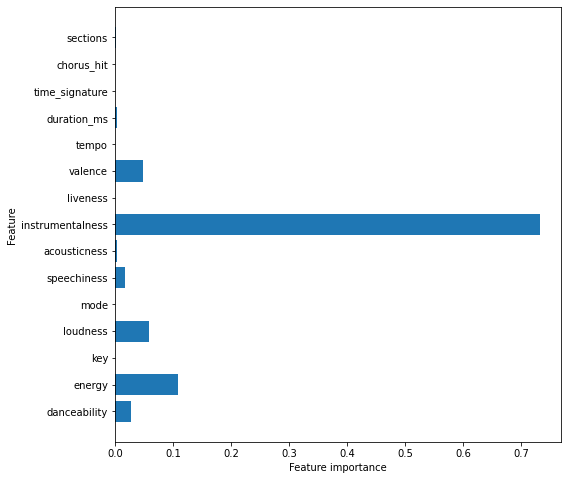

In [11]:
# Plotting feature importances
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(baseline_tree)


In [12]:
# Model Performance
# Generate predictions
# Print out a confusion matrix of test set preds.
# Print out classification report

pred = baseline_tree.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[596 211]
 [ 98 695]]
              precision    recall  f1-score   support

           0       0.86      0.74      0.79       807
           1       0.77      0.88      0.82       793

    accuracy                           0.81      1600
   macro avg       0.81      0.81      0.81      1600
weighted avg       0.81      0.81      0.81      1600



In [13]:
# Checking model accuracy
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))


Testing Accuracy for Decision Tree Classifier: 80.69%


In [14]:
# cross val score for baseline tree
dt_clf = DecisionTreeClassifier()
dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 78.12%


In [ ]:
dt_param_grid ={
    ???
}

In [15]:
# Baseline DT grid search
dt_grid_search = GridSearchCV(dt_clf , dt_param_grid, cv=3, return_train_score=True)

dt_grid_search.fit(X_train, y_train)

NameError: name 'dt_param_grid' is not defined

## Modeling

In [18]:
#trying to improve the baseline model - random forest

In [18]:
#Fit a random forests model
forest = RandomForestClassifier(n_estimators=100, max_depth=5)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [20]:
# Checking training and testing accuracy of the model
forest.score(X_train, y_train)

0.8403501458941226

In [21]:
forest.score(X_test, y_test)

0.81875

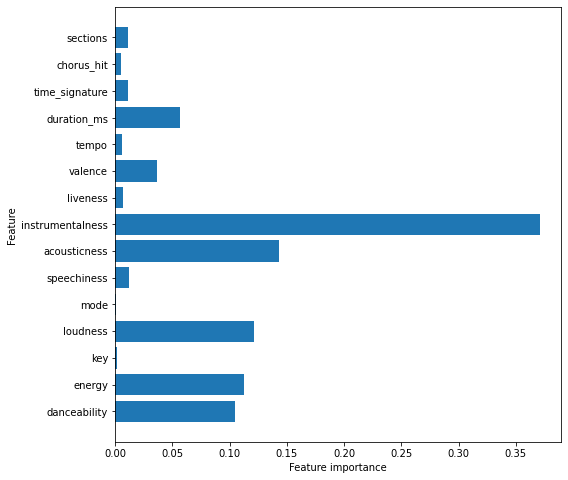

In [22]:
# Feature importance
plot_feature_importances(forest)

In [26]:
# tuning the random forest model
mean_rf_cv_score = np.mean(cross_val_score(forest, X_train, y_train, cv=3))

print(
    f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}"
)

Mean Cross Validation Score for Random Forest Classifier: 82.60%


In [27]:
# Now, we create a parameter grid specific to our random forest classifier
rf_param_grid = {
   "n_estimators": [10, 30, 100],
    "criterion": ['gini', 'entropy'],
    "max_depth": [None, 2, 6, 10],
    "min_samples_split": [5, 10],
    "min_samples_split": [3, 6]
}
# What params???

## Come back to this ^^ - you used the default params from the lab but which ones should you actually use??

In [30]:
# Now perform the GridSearchCV
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 84.60%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 6, 'n_estimators': 100}


In [31]:
# Which model performed best on the test set?
#dt_score = dt_grid_search.score(X_test, y_test)
#rf_score = rf_grid_search.score(X_test, y_test)

#print("Decision tree grid search: ", dt_score)
#print("Random forest grid search: ", rf_score)

NameError: name 'dt_grid_search' is not defined

## Evaluation

## Deployment